In [1]:
import pandas as pd
from pandas import read_csv
import os
from os import listdir
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync/')

plt.style.use('ggplot')
sns.set(font_scale=1.4)  # larger font

In [2]:
analysis_years = [2018, 2040]
faf_code = [481,488,489]
combined_b2b_flow = None

output_dir_lookup = {2018: 'outputs_aus_2018',
                     2040: 'outputs_aus_2040'
}
for year in analysis_years:
    directory_to_load = output_dir_lookup[year]
    b2b_flow_by_year = read_csv(directory_to_load + '/processed_b2b_flow_summary.csv')
    b2b_flow_by_year.loc[:, 'Year'] = year
    combined_b2b_flow = pd.concat([combined_b2b_flow, b2b_flow_by_year])
    
combined_b2b_flow.head(5)    

,Unnamed: 0,orig_FAFID,orig_FAFNAME,dest_FAFID,dest_FAFNAME,SCTG_Group,SCTG_Name,mode_choice,tmiles,ShipmentLoad,count,outbound,inbound,Distance,Year
0,0,11,Birmingham,481,Austin,1,bulk,Rail/IMX,1.593488e+08,160.159165,10,0,1,994.940199,2018
1,1,11,Birmingham,481,Austin,4,mfr_goods,Air,1.064365e+04,0.015666,82,0,1,679.394153,2018
2,2,11,Birmingham,481,Austin,4,mfr_goods,For-hire Truck,9.009721e+06,10.503779,3091,0,1,857.760000,2018
3,3,11,Birmingham,481,Austin,4,mfr_goods,Rail/IMX,1.611286e+06,1.619481,81,0,1,994.940199,2018
4,4,11,Birmingham,488,San Antonio,1,bulk,For-hire Truck,4.098013e+06,4.327455,95,0,1,946.980000,2018


In [3]:
# total production
print(len(combined_b2b_flow))
region_production = \
combined_b2b_flow.loc[combined_b2b_flow['orig_FAFID'].isin(faf_code)]
print(len(region_production))
region_production_total = \
region_production.groupby(['Year', 'mode_choice'])[['ShipmentLoad']].sum()
region_production_total = region_production_total.reset_index()
region_production_to_plot = \
pd.pivot_table(region_production_total,
               values='ShipmentLoad', 
               index=['Year'],
               columns=['mode_choice'], 
               aggfunc=np.sum, sort = False)
region_production_to_plot.loc[:, 'Total load'] = \
region_production_to_plot.sum(axis = 1)
region_production_to_plot.loc[:, 'Truck load'] = \
region_production_to_plot.loc[:, 'For-hire Truck'] + region_production_to_plot.loc[:, 'Private Truck']
region_production_to_plot = region_production_to_plot.reset_index()
region_production_to_plot = region_production_to_plot[['Year', 'Total load', 'Truck load']]

region_production_to_plot.head(5)

6242
3590


mode_choice,Year,Total load,Truck load
0,2018,9.880411e+05,790424.242732
1,2040,1.315166e+06,909863.977438


In [4]:
# total consumption
print(len(combined_b2b_flow))
region_consumption = \
combined_b2b_flow.loc[combined_b2b_flow['dest_FAFID'].isin(faf_code)]
print(len(region_consumption))
region_consumption_total = \
region_consumption.groupby(['Year', 'mode_choice'])[['ShipmentLoad']].sum()
region_consumption_total = region_consumption_total.reset_index()
region_consumption_to_plot = \
pd.pivot_table(region_consumption_total,
               values='ShipmentLoad', 
               index=['Year'],
               columns=['mode_choice'], 
               aggfunc=np.sum, sort = False)
region_consumption_to_plot.loc[:, 'Total load'] = \
region_consumption_to_plot.sum(axis = 1)
region_consumption_to_plot.loc[:, 'Truck load'] = \
region_consumption_to_plot.loc[:, 'For-hire Truck'] + \
region_consumption_to_plot.loc[:, 'Private Truck']
region_consumption_to_plot = region_consumption_to_plot.reset_index()
region_consumption_to_plot = region_consumption_to_plot[['Year', 'Total load', 'Truck load']]
region_consumption_to_plot.head(5)

6242
2913


mode_choice,Year,Total load,Truck load
0,2018,857982.992869,794279.850601
1,2040,908865.394706,790347.837251


In [5]:
region_production_to_plot.columns = \
['Year', 'Total production (1000 ton)', 'Production shipped by truck (1000 ton)']
region_consumption_to_plot.columns = \
['Year', 'Total consumption (1000 ton)', 'Consumption shipped by truck (1000 ton)']
region_flow_to_plot = pd.merge(region_production_to_plot,
                              region_consumption_to_plot,
                              on = 'Year', how = 'left')
region_flow_to_plot.loc[:, 'Total load'] = \
region_flow_to_plot.loc[:, 'Total production (1000 ton)'] + \
region_flow_to_plot.loc[:, 'Total consumption (1000 ton)']

region_flow_to_plot.loc[:, 'Truck load'] = \
region_flow_to_plot.loc[:, 'Production shipped by truck (1000 ton)'] + \
region_flow_to_plot.loc[:, 'Consumption shipped by truck (1000 ton)']
region_flow_to_plot.head(5)


,Year,Total production (1000 ton),Production shipped by truck (1000 ton),Total consumption (1000 ton),Consumption shipped by truck (1000 ton),Total load,Truck load
0,2018,9.880411e+05,790424.242732,857982.992869,794279.850601,1.846024e+06,1.584704e+06
1,2040,1.315166e+06,909863.977438,908865.394706,790347.837251,2.224031e+06,1.700212e+06


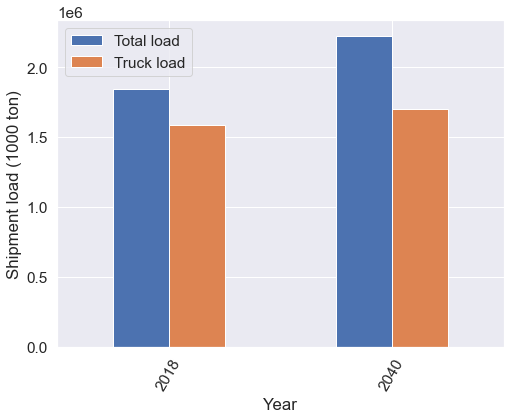

In [6]:
# plt.figure(figsize = (6,5))
region_flow_to_plot[['Year', 'Total load', \
                     'Truck load']].plot(kind = 'bar', x = 'Year', figsize=(8,6))
plt.xticks(rotation = 60)
plt.ylabel('Shipment load (1000 ton)')
plt.savefig('plots/SynthFirm_demand_forecast.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [10]:
region_flow_to_plot.to_csv('outputs_SF/SynthFirm_demand_forecast_SF.csv')